<a href="https://colab.research.google.com/github/hsieh2000/HW/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ckip_transformers
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 104.9 MB/s eta 0:00:00


In [24]:
import os
import re
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer


In [4]:
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker
# Initialize drivers
print("Initializing drivers ... WS")
ws_driver = CkipWordSegmenter(model="bert-base", device=-1)
print("Initializing drivers ... POS")
pos_driver = CkipPosTagger(model="bert-base", device=-1)
print("Initializing drivers ... NER")
ner_driver = CkipNerChunker(model="bert-base", device=-1)
print("Initializing drivers ... all done")
print()

Initializing drivers ... WS


Initializing drivers ... POS


Initializing drivers ... NER


Initializing drivers ... all done



In [5]:
os.chdir("/content/drive/MyDrive/NLP")

In [45]:
ORIGINAL_DATA = pd.read_csv("data.csv")
ORIGINAL_DATA = ORIGINAL_DATA.drop(columns = ["Unnamed: 0"])

TEST_DATA = ORIGINAL_DATA[:100]
content = TEST_DATA["content"]


In [46]:
TEST_DATA

,article_title,content,message_count_all,message_count_boo,message_count_count,message_count_neutral,message_count_push
0,[狂幹] 孫運璿 vs 陳水扁,孫前院長和陳水扁的比較： 出身貧窮人家，苦讀完成學業，非經濟科班出身，任公職後，卻能為國拼出...,233,49,58,77,107
1,[無言] 國王的新衣,變調的童話：國王的新衣 他能在眾王子的爭奪戰中脫穎而出，除了自身的實力 其實也背負著全國極欲...,85,7,32,39,39
2,[吐嘈] =====沈老大在53台，婊DPP的4個影片片段=====,2006/05/17 民視新聞台 頭家來開講 婊DPP的4個clips 每一段都是切重要害的...,47,3,27,14,30
3,[大話] 笑話新聞 徐議員批馬片段,其實不只有徐議員啦 其他的人的講法 也大多都有入鏡 =================分格線...,21,1,11,8,12
4,[轉錄][囧rz]安西教練：「三井，你負責投外線！」,作者: mushishi (蟲師) 看板: joke 標題: [囧rz]安西教練：三井，你負...,150,3,134,10,137
...,...,...,...,...,...,...,...
95,[震怒] 永和的人民同意了這個決定!,作者 wwwscc (12) 看板 HatePolitics 標題 [震怒] 永和的人民同意...,20,0,16,4,16
96,[惡搞] 2026年的報紙頭版頭,首頁焦點話題南北台再度建交 評論 轉寄 列印 光輝十月 中華民國宣布與台灣國再度建交 記者艾...,114,0,104,10,104
97,[惡搞] 豪洨新聞--主席成耗材？民勁黨主席難產,自從民勁黨前主席蔡煌郎因承擔2008年總統大選敗選責任辭職後，前副總統呂琇蓮 又再度接下代理...,6,0,5,1,5
98,"第N共和國,請以大韓民國為借鏡",第一共和: 1948年大韓民國成立憲法為總統制李承晚當選總統後厲行獨裁 在1960年的人民革...,14,0,11,3,11


In [ ]:
# ws_results = ws_driver([content[0]])
# pos_results = pos_driver([content[0]])
# ner_results = ner_driver([content[0]])
# print(ws_results[0])
# print(pos_results[0])
# print(ner_results[0])



In [47]:
def read_stopword():
    with open("./stopwords_TW.txt", "r", encoding="utf-8") as f:
        stopword = [word.strip("\n") for word in f.readlines()]
    return stopword
stopwords = read_stopword()

def do_CKIP_WS(article):
  ws_results = ws_driver([article])
  return ws_results

def do_CKIP_POS(ws_result):
    # write your code in here
    pos = pos_driver(ws_result[0])
    all_list = []
    for sent in pos:

      all_list.append(sent)
    return all_list

def pos_filter(pos):
  for i in list(set(pos)):
    if i.startswith("N") or i.startswith("V"):
      return "Yes"
    else:
      continue

def cleaner(ws_results, pos_results, stopwords):
  word_lst = []
  for ws, pos in zip(ws_results[0], pos_results):
    in_stopwords_or_not = ws not in stopwords
    if_len_greater_than_1 = len(ws) > 1
    is_V_or_N = pos_filter(pos)
    if in_stopwords_or_not and if_len_greater_than_1 and is_V_or_N == "Yes":
      word_lst.append(ws)
    else:
      pass
  return word_lst


In [48]:
seg_lst = []
for i in range(len(TEST_DATA)):
  ws_results = do_CKIP_WS(content[i])
  pos_results = do_CKIP_POS(ws_results)
  word_lst = cleaner(ws_results, pos_results, stopwords)
  seg_lst.append(word_lst)


Inference: 100%|██████████| 1/1 [00:08<00:00,  8.25s/it]


In [50]:
word_count = Counter()
for i in seg_lst:
  word = Counter(i)
  word_count+=word
  

(-0.5, 399.5, 199.5, -0.5)

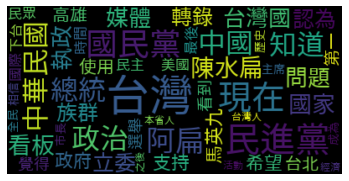

In [51]:
# -*- coding: utf-8 -*-
from wordcloud import WordCloud
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib.font_manager import fontManager
from collections import Counter

font_path = '/content/drive/MyDrive/NLP/TaipeiSansTCBeta-Regular.ttf'
wordcloud = WordCloud(max_words = 50, font_path=font_path).generate_from_frequencies(word_count)
# cloud.to_file('output.png')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [52]:
word_count

Counter({'前院長': 1,
         '陳水扁': 65,
         '出身': 6,
         '貧窮': 3,
         '苦讀': 2,
         '完成': 7,
         '學業': 2,
         '經濟': 29,
         '科班': 2,
         '公職': 2,
         '拼出': 2,
         '亮麗': 3,
         '成果': 3,
         '山東': 1,
         '台灣': 190,
         '帶領': 3,
         '破敗': 2,
         '走向': 7,
         '繁榮': 5,
         '台南': 9,
         '台北': 42,
         '傳記': 1,
         '兒子': 17,
         '當兵': 8,
         '國防部長': 1,
         '知道': 71,
         '報導': 14,
         '積架車': 1,
         '上下班': 1,
         '工商界': 2,
         '解決': 10,
         '經營': 7,
         '問題': 55,
         '瞭解': 3,
         '事蹟': 2,
         '心情': 5,
         '感動': 6,
         '飆淚': 1,
         '激動': 2,
         '開罵': 1,
         '風範': 4,
         '地方': 23,
         '展現': 4,
         '玷污': 1,
         '先生': 10,
         '變調': 1,
         '童話': 3,
         '國王': 8,
         '新衣': 4,
         '王子': 4,
         '爭奪戰': 3,
         '脫穎而出': 1,
         '實力': 1,
         '背負': 1,
      

In [53]:
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel


In [54]:
dictionary = corpora.Dictionary(seg_lst)
corpus = [dictionary.doc2bow(i) for i in seg_lst]

In [56]:
corpus[0]

[(0, 1),
 (1, 2),
 (2, 2),
 (3, 1),
 (4, 1),
 (5, 2),
 (6, 2),
 (7, 4),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 5),
 (12, 2),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 2),
 (17, 2),
 (18, 1),
 (19, 1),
 (20, 2),
 (21, 2),
 (22, 2),
 (23, 1),
 (24, 2),
 (25, 2),
 (26, 1),
 (27, 1),
 (28, 2),
 (29, 2),
 (30, 1),
 (31, 2),
 (32, 2),
 (33, 1),
 (34, 5),
 (35, 1),
 (36, 2),
 (37, 2),
 (38, 2),
 (39, 2),
 (40, 2),
 (41, 1),
 (42, 1),
 (43, 1),
 (44, 1)]

In [59]:
def perplexity(num_topics):
  ldamodel = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes = 30)
  print(ldamodel.print_topics(num_topics = num_topics, num_words = 15))
  print(ldamodel.log_perplexity(corpus))
  return ldamodel.log_perplexity(corpus)

def coherence(num_topics):
  ldamodel = LdaModel(corpus, num_topics = num_topics, id2word = dictionary, passes = 30, random_state = 42)
  print(ldamodel.print_topics(num_topics = num_topics, num_words = 15))
  ldacm = CoherenceModel(model = ldamodel, texts = seg_lst, dictionary = dictionary, coherence="c_v")
  print(ldacm.get_coherence())
  return ldacm.get_coherence()

[(0, '0.007*"台灣" + 0.004*"民進黨" + 0.004*"現在" + 0.003*"國民黨" + 0.003*"阿扁" + 0.003*"政治" + 0.003*"中國" + 0.003*"中華民國" + 0.003*"總統" + 0.002*"知道" + 0.002*"陳水扁" + 0.002*"國家" + 0.002*"看板" + 0.002*"台灣國" + 0.002*"問題"')]
-8.669290248039713
[(0, '0.006*"民進黨" + 0.004*"現在" + 0.004*"國民黨" + 0.004*"政治" + 0.004*"阿扁" + 0.004*"陳水扁" + 0.003*"知道" + 0.003*"高雄" + 0.003*"台灣" + 0.002*"第一" + 0.002*"立委" + 0.002*"支持" + 0.002*"執政" + 0.002*"全民" + 0.002*"民主"'), (1, '0.010*"台灣" + 0.004*"中國" + 0.004*"中華民國" + 0.004*"台灣國" + 0.003*"國家" + 0.003*"現在" + 0.003*"總統" + 0.003*"國民黨" + 0.003*"民進黨" + 0.003*"族群" + 0.003*"問題" + 0.003*"使用" + 0.002*"看板" + 0.002*"阿扁" + 0.002*"認為"')]
-8.650212570162655
[(0, '0.006*"台灣國" + 0.004*"民進黨" + 0.004*"台灣" + 0.004*"立委" + 0.004*"中華民國" + 0.004*"國民黨" + 0.004*"陳水扁" + 0.003*"現在" + 0.003*"總統" + 0.003*"使用" + 0.003*"全民" + 0.003*"媒體" + 0.003*"阿扁" + 0.002*"建交" + 0.002*"彰化"'), (1, '0.011*"台灣" + 0.005*"中國" + 0.004*"民進黨" + 0.004*"族群" + 0.004*"阿扁" + 0.004*"知道" + 0.004*"政治" + 0.004*"國民黨" + 0.003*"現在" + 0.003*"問題" 

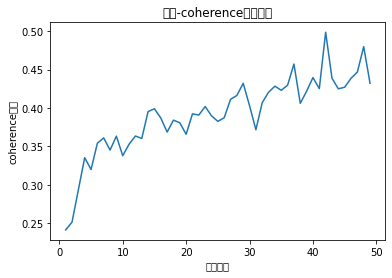

In [61]:
x = range(1,50)
z = [perplexity(i) for i in x]
y = [coherence(i) for i in x]

plt.plot(x,y)
plt.xlabel("主題數目")
plt.ylabel("coherence大小")
plt.rcParams["font.sans-serif"] = ["SimHei"]
matplotlib.rcParams["axes.unicode_minus"] = False
plt.title("主題-coherence變化情形")
plt.show()

In [62]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=c867df56f4cc33901ea61ae8747d7257e2c385eeb9b5b0a9a528ddc66c4b7627
  Stored in directory: /root/.cache/pip/wheels/90/61/ec/9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=794cac98d9fdf404b0a88109dbab98320b6fa6dd9ffbd148e5e88144666e4809
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built pyLDAvis sklearn


In [66]:
lda = LdaModel(corpus, num_topics = 42, id2word = dictionary, passes = 30, random_state = 42)
topics_lst = lda.print_topics()
print(topics_lst)

import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
data = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary)
pyLDAvis.save_html(data, "./topic_model.html")

串流輸出內容已截斷至最後 5000 行。
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elog

[(8, '0.049*"使用" + 0.026*"效果" + 0.026*"不及" + 0.020*"限制" + 0.012*"我方" + 0.008*"全體" + 0.008*"阿貶" + 0.007*"馬英九" + 0.007*"亂童" + 0.007*"抬玩"'), (27, '0.013*"抱歉" + 0.009*"中立" + 0.009*"高層" + 0.006*"政治" + 0.006*"身體" + 0.006*"做到" + 0.006*"好好" + 0.006*"取締" + 0.006*"髒話" + 0.006*"綠軍"'), (18, '0.015*"股東" + 0.013*"公司" + 0.009*"資金" + 0.007*"幕後" + 0.007*"股價" + 0.007*"龐大" + 0.006*"幹部" + 0.006*"交易" + 0.005*"影響" + 0.005*"公開"'), (41, '0.019*"基金會" + 0.017*"第一" + 0.014*"董事長" + 0.009*"台糖" + 0.009*"糖協" + 0.009*"阿扁" + 0.006*"武智" + 0.006*"監察人" + 0.006*"涉入" + 0.006*"國防部"'), (39, '0.009*"扁帝" + 0.009*"護短" + 0.005*"藥商" + 0.005*"無力" + 0.005*"貪婪" + 0.005*"台開" + 0.005*"切割" + 0.005*"淑珍" + 0.005*"台邱" + 0.005*"將軍"'), (23, '0.013*"公務員" + 0.012*"共和" + 0.008*"台灣" + 0.008*"希望" + 0.006*"執政" + 0.006*"現在" + 0.006*"道歉" + 0.006*"成立" + 0.006*"拿破崙" + 0.006*"福利"'), (21, '0.045*"台灣國" + 0.023*"建交" + 0.020*"中華民國" + 0.011*"和平" + 0.010*"台北" + 0.008*"濁水溪" + 0.007*"表示" + 0.007*"總統" + 0.006*"女王" + 0.006*"看法"'), (2, '0.044*"中華民國" + 0.020*"國家"

In [22]:
seg_concat_lst = [" ".join(i) for i in seg_lst]

In [30]:
TEST_DATA["seg_concat_lst"] = seg_concat_lst
TEST_DATA

<ipython-input-30-698c92289467>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TEST_DATA["seg_concat_lst"] = seg_concat_lst


,article_title,content,message_count_all,message_count_boo,message_count_count,message_count_neutral,message_count_push,seg_concat_lst
0,[狂幹] 孫運璿 vs 陳水扁,孫前院長和陳水扁的比較： 出身貧窮人家，苦讀完成學業，非經濟科班出身，任公職後，卻能為國拼出...,233,49,58,77,107,前院長 陳水扁 出身 貧窮 苦讀 完成 學業 經濟 科班 出身 公職 拼出 亮麗 經濟 成果...
1,[無言] 國王的新衣,變調的童話：國王的新衣 他能在眾王子的爭奪戰中脫穎而出，除了自身的實力 其實也背負著全國極欲...,85,7,32,39,39,變調 童話 國王 新衣 王子 爭奪戰 脫穎而出 實力 背負 改變 革新 廉潔 民眾 期待 加...
2,[吐嘈] =====沈老大在53台，婊DPP的4個影片片段=====,2006/05/17 民視新聞台 頭家來開講 婊DPP的4個clips 每一段都是切重要害的...,47,3,27,14,30,2006/05/17 民視 新聞台 頭家 開講 婊 切重 要害 檢討 清流 阿清流 綠色...
3,[大話] 笑話新聞 徐議員批馬片段,其實不只有徐議員啦 其他的人的講法 也大多都有入鏡 =================分格線...,21,1,11,8,12,議員 講法 入鏡 分格線 建議 第3 4 斟酌 第一 UP0x0 第二 http://w...
4,[轉錄][囧rz]安西教練：「三井，你負責投外線！」,作者: mushishi (蟲師) 看板: joke 標題: [囧rz]安西教練：三井，你負...,150,3,134,10,137,作者 蟲師 看板 標題 安西 教練 三井 負責 外線 時間 22 01:35:45 200...
5,[惡搞] 羞身 歧家 滯國 貧天下,這就是扁最好的寫照: 羞身 滿嘴粗言惡語罄竹難書.口口聲聲 嘔臭了嗎. 歧家 全家大大小小都...,43,3,24,13,27,寫照 羞身 粗言 惡語 罄竹難書 口口 聲聲 嘔臭 歧家 大大小小 貪瀆 奢侈 濫用 公權...
6,Re: 大陸人樂什麼樂阿,轉錄些中國人對駙馬事件的有趣評論 拚命抹黑.(指CCTV) 剛好讓人對比什麼是光明什麼是黑暗...,28,3,16,6,19,轉錄 中國人 駙馬 事件 有趣 評論 拚命 抹黑 對比 光明 黑暗 弄巧成拙 邱毅 橫屍 街...
7,[轉錄][囧rz] 改的不好請見諒!陋室銘之趙建銘版!,作者: germ0807 (大喊小牛加油) 看板: joke 標題: [囧rz] 改的不好請...,35,2,16,15,18,作者 germ0807 大喊 小牛 加油 看板 標題 見諒 陋室銘 趙建銘 時間 30 ...
8,[吐嘈] 民進黨的反撲...,拉法葉案各位 是拉法葉案啊 天啊，我感動的快要哭了，沒有想到民進黨還記得拉法葉案 想當初阿扁...,32,2,22,6,24,拉法葉案 拉法葉案 感動 想到 民進黨 記得 拉法葉案 當初 阿扁 上台 信誓蛋蛋 動搖 國...
9,[吐嘈] 阿扁向人民報告－收視率走勢圖,40 兩蔣權力大也沒人敢管 30 沒介入SOGO 不知道台開 20 10 我是族群對立的受...,10,1,6,2,7,40 兩蔣 權力 30 介入 知道 台開 20 10 族群 對立 受害 20:...


In [36]:
tf_idf_vectorizer = TfidfVectorizer()
tf_idf = tf_idf_vectorizer.fit_transform(TEST_DATA["seg_concat_lst"])
feature_names = tf_idf_vectorizer.get_feature_names()


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [37]:
feature_names

['00',
 '01',
 '02',
 '03',
 '04',
 '05',
 '08',
 '10',
 '17',
 '18',
 '20',
 '2006',
 '21',
 '22',
 '30',
 '35',
 '37',
 '40',
 '45',
 '48',
 '51',
 '53',
 '56',
 '8_ws2',
 'azkh0oms8',
 'com',
 'ctsh94301',
 'germ0807',
 'gktokjdtua',
 'http',
 'j3it8k',
 'k44eku',
 'ks',
 'loveyanzi03',
 'ns',
 'o8dviy4xds',
 'udie2',
 'up0x0',
 'watch',
 'www',
 'youtube',
 '一下',
 '一些',
 '一度',
 '一成',
 '三井',
 '上下班',
 '上台',
 '下去',
 '不實',
 '不張',
 '不斷',
 '不覺',
 '不錯',
 '中下',
 '中國人',
 '中央',
 '中心',
 '中鋒',
 '主管',
 '之上',
 '之間',
 '九品',
 '亂耳',
 '了事',
 '事件',
 '事實',
 '事蹟',
 '交給',
 '亮麗',
 '人士',
 '今天',
 '介入',
 '付出',
 '代標',
 '代表',
 '任職',
 '低調',
 '作者',
 '保證',
 '信任度',
 '信誓蛋蛋',
 '個個',
 '停損點',
 '健全',
 '偷渡',
 '傳記',
 '優越性',
 '兄弟',
 '先生',
 '光明',
 '兒子',
 '入鏡',
 '內線',
 '全民',
 '兩蔣',
 '公平',
 '公權力',
 '公職',
 '兵營',
 '典禮',
 '凡人',
 '出國',
 '出身',
 '分子',
 '分格線',
 '切割',
 '切重',
 '判斷力',
 '利益',
 '制度',
 '刻意',
 '前院長',
 '前面',
 '劉駿',
 '力量',
 '加冕',
 '加油',
 '努力',
 '勇敢',
 '動搖',
 '動機',
 '勝利',
 '勞形',
 '包括',
 '千夫長',
 '南陽',
 '原文版',
 '反面',
 '受害',
 

In [13]:
ner_lst = []
for i in range(0,10):
  ner_results = ner_driver([content[i]])
  ner_filter=['PERSON','ORG','GPE','MONEY','NORP','LOC','FAC','EVENT','PRODUCT','LAW']
  ner = [(j.word, j.ner) for j in ner_results[0] if j.ner in ner_filter]
  ner_lst.append(ner)


Inference: 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


In [23]:
ner_lst

[[('陳水扁', 'PERSON'),
  ('山東', 'GPE'),
  ('台灣', 'GPE'),
  ('台灣', 'GPE'),
  ('台灣', 'GPE'),
  ('台南', 'GPE'),
  ('台北', 'GPE'),
  ('台灣', 'GPE'),
  ('台灣', 'GPE'),
  ('國防部長', 'ORG')],
 [],
 [],
 [],
 [('趙建銘', 'PERSON')],
 [('扁', 'PERSON'), ('台灣', 'NORP'), ('民進黨', 'ORG'), ('呂游謝蘇', 'PERSON')],
 [('中國人', 'NORP'),
  ('大陸', 'GPE'),
  ('大陸', 'GPE'),
  ('台灣', 'GPE'),
  ('台灣', 'GPE'),
  ('大陸', 'GPE'),
  ('央視', 'ORG'),
  ('台灣', 'GPE'),
  ('大陸', 'GPE'),
  ('台灣', 'GPE'),
  ('陳水扁', 'PERSON'),
  ('大陸', 'GPE'),
  ('大陸', 'GPE'),
  ('央視', 'ORG'),
  ('阿扁', 'PERSON'),
  ('大陸', 'GPE'),
  ('中央', 'ORG'),
  ('央視', 'ORG'),
  ('台灣', 'GPE'),
  ('央視', 'ORG'),
  ('台獨', 'GPE'),
  ('台灣', 'GPE'),
  ('阿扁', 'PERSON'),
  ('鄭恩寵', 'PERSON'),
  ('劉駿', 'PERSON'),
  ('李尚平', 'PERSON'),
  ('阿扁', 'PERSON'),
  ('中國人', 'NORP')],
 [('趙建銘', 'PERSON'), ('趙建銘', 'PERSON'), ('台北', 'GPE'), ('阿扁', 'PERSON')],
 [('拉法葉案', 'EVENT'),
  ('拉法葉案', 'EVENT'),
  ('民進黨', 'ORG'),
  ('拉法葉案', 'EVENT'),
  ('阿扁', 'PERSON'),
  ('阿扁', 'PERSON'),
  ('柯建銘', 'PER

In [24]:
ner_list = pd.DataFrame()
ner_list["ner_lst"] = ner_lst
ner_list.to_csv("/content/drive/MyDrive/NLP/ner_lst.csv", encoding='utf-8')

In [ ]:
def NER_select(ner_lst, ner_type):
  NER_count = Counter()
  for i in ner_lst:
    for j in i:
      n = []
      if j[1] == ner_type and len(j[0]) > 1:
        n.append(j[0])

      ner_count = Counter(n)
      NER_count+=ner_count

  return NER_count

NER_count = NER_select(ner_lst, "PERSON")


(-0.5, 399.5, 199.5, -0.5)

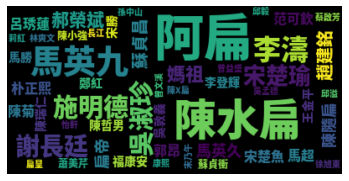

In [ ]:
font_path = '/content/NotoSansTC-Black.otf'
wordcloud = WordCloud(max_words = 50, font_path=font_path).generate_from_frequencies(NER_count)
# cloud.to_file('output.png')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")